In [1]:
import copy
import numpy as np
import pandas as pd 
from joblib import dump, load
import matplotlib.pyplot as plt
from epigraphhub.analysis.preprocessing import build_lagged_features
from epigraphhub.data.foph import get_cluster_data
from epigraphhub.analysis.forecast_models.ngboost_models import get_targets 
from forecast_swiss import get_cluster_by_canton

{'dbname': 'epigraphhub', 'host': 'localhost', 'password': 'epigraph', 'port': 5432, 'username': 'epigraph'}


In [2]:
def load_evaluate(target_curve_name, canton, predictors = ['foph_test_d', 'foph_cases_d', 'foph_hosp_d'],  ini_date = '2020-05-01', end_date = None,  predict_n = 14, look_back = 14, path = 'saved_models_dash'):
    
    target_name = f'{target_curve_name}_{canton}'
    
    cluster = get_cluster_by_canton(canton)
    
    data = get_cluster_data(
            "switzerland", predictors, list(cluster), vaccine=True, smooth=True 
        )

    data = data.fillna(0)            
    
    df_lag = build_lagged_features(copy.deepcopy(data), maxlag = look_back)

    if ini_date != None: 
        df_lag = df_lag[ini_date:]

    if end_date != None: 
        df_lag = df_lag[:end_date]

    df_lag = df_lag.dropna()

    target = df_lag[target_name]

    targets = get_targets(target, predict_n)

    # remove the target column and columns related with the day that we want to predict
    df_lag = df_lag.drop(data.columns, axis=1)

    idx = pd.period_range(
            start=df_lag.index[0], end=df_lag.index[-1], freq=f"{predict_n}D"
        )
     
    idx = idx.to_timestamp()

    preds5 = np.empty((len(idx), predict_n))
    preds50 = np.empty((len(idx), predict_n))
    preds95 = np.empty((len(idx), predict_n))

    for T in range(1, predict_n + 1):

        tgt = targets[T]

        model = load(f"{path}/ngboost_{target_name}_{T}.joblib")

        pred = model.pred_dist(df_lag.loc[idx], max_iter = model.best_val_loss_itr)

        pred50 = pred.median()

        pred5, pred95 = pred.interval(alpha=0.95)

        preds5[:, (T - 1)] = pred5
        preds50[:, (T - 1)] = pred50
        preds95[:, (T - 1)] = pred95


    y5 = preds5.flatten()
    y50 = preds50.flatten()
    y95 = preds95.flatten()

    x = pd.period_range(
            start=df_lag.index[1], end=df_lag.index[-1], freq="D"
        ).to_timestamp()

    x = np.array(x)

    y5 = np.array(y5)

    y50 = np.array(y50)

    y95 = np.array(y95)

    dif = len(x) - len(y5)

    if dif < 0:
        y5 = y5[: len(y5) + dif]
        y50 = y50[: len(y50) + dif]
        y95 = y95[: len(y95) + dif]

    df_pred = pd.DataFrame()
    df_pred["target"] = target[1:]
    df_pred["date"] = x
    df_pred["lower"] = y5
    df_pred["median"] = y50
    df_pred["upper"] = y95
    df_pred.set_index('date', inplace = True)
    df_pred.index = pd.to_datetime(df_pred.index)
    
    return df_pred


In [3]:
%%time
target_curve_name = 'hosp'
canton = 'GE'
df = load_evaluate(target_curve_name, canton)
    

CPU times: user 2.19 s, sys: 122 ms, total: 2.31 s
Wall time: 25.3 s


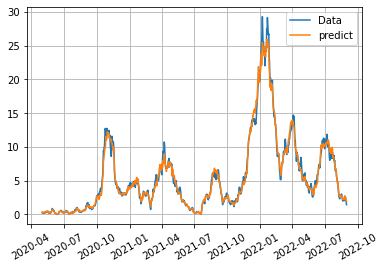

In [4]:
plt.figure()

plt.plot(df['target'], label = 'Data')
plt.plot(df['median'], label = 'predict')

plt.legend()
plt.xticks(rotation = 30)
plt.grid()
plt.show()